# Vendors.csv analysis

Check the vendors.csv file, filter only classified samples

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_folder = 'data/'
vendors_file = data_folder + 'vendors.csv.gz'
reports_file = data_folder + 'reports.csv.gz'

In [11]:
reports = pd.read_csv(reports_file)
reports = reports.set_index('link')
# Sanity check
assert len(reports[~reports.file_type.str.startswith('PE32')]) == 0
reports.drop(['file_name', 'file_size', 'file_type'], axis=1, inplace=True)
reports.date = pd.to_datetime(reports.date, infer_datetime_format=True)

vendors = pd.read_csv(vendors_file, dtype=str)
vendors = vendors.set_index('link')
# First column is thrash
# vendors.drop(vendors.columns[0], axis=1, inplace=True)
# Drop never classified samples
vendors.dropna(how='all', inplace=True)

In [12]:
display('Classified samples: {}'.format(len(vendors)))

'Classified samples: 292127'

In [13]:
# vendors.to_csv(vendors_file, compression='gzip')

In [14]:
reports_vendors = reports.join(vendors, how='inner')

# Evolution on duplicated samples

Check how duplicated samples change classification. Takes into account every submission of the same sample, looking for the differences between classifications.

In [15]:
# Duplicated md5s
md5_dups = set(reports_vendors[reports_vendors.md5.duplicated()].md5)
reports_filtered = reports_vendors[reports_vendors.md5.isin(md5_dups)]
vendors_count = reports_filtered.replace('Clean', np.nan).groupby(['md5', 'date']).count().sum(axis=1).reset_index('date')

In [16]:
differences = []
# Calculate the pairwise difference between reports
for md5 in set(vendors_count.index):
    temp = vendors_count[vendors_count.index == md5].sort_values('date', ascending=False)
    count = list(temp[0])
    if sum(count) == 0:
        continue
    differences += [x - y for x, y in zip(count, count[1:])]

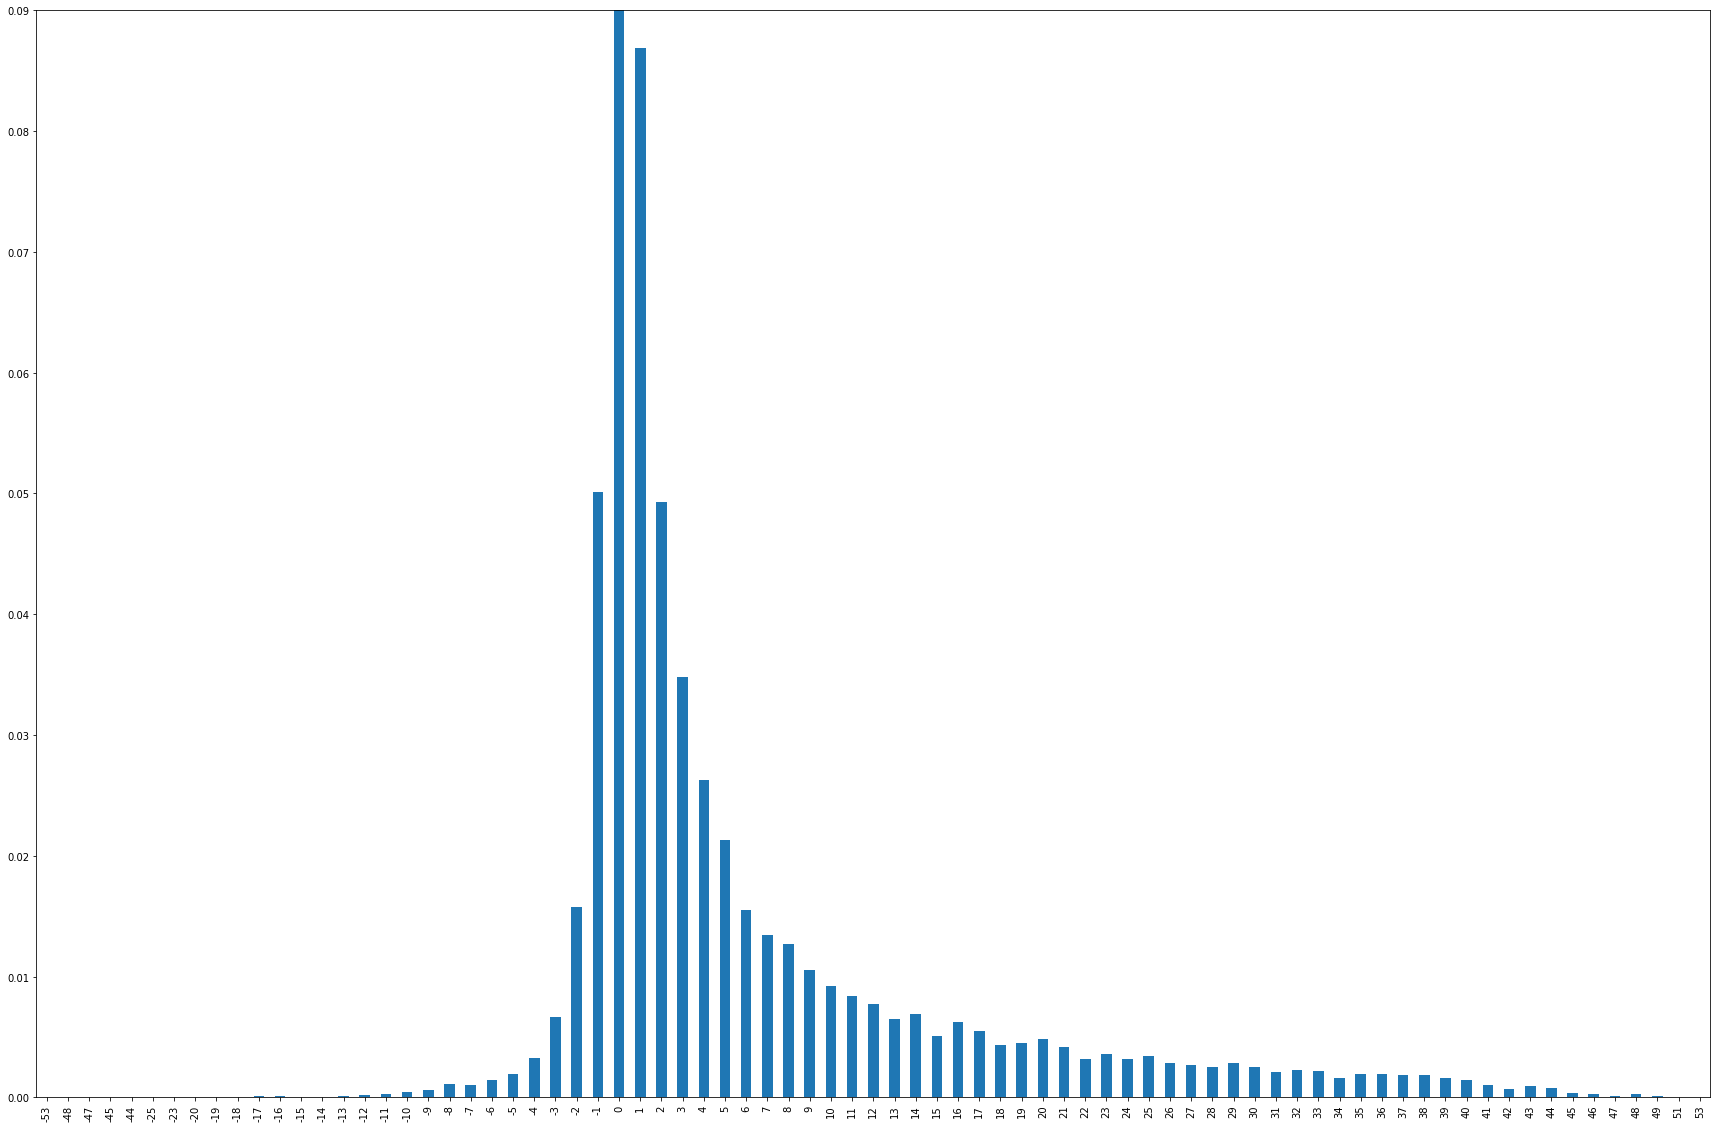

In [17]:
diff_series = pd.Series(differences)
diff_series.value_counts().sort_index().divide(len(diff_series)).plot.bar(figsize=((30, 20)), ylim=(0, 0.09))
plt.show()

In [9]:
%%time
# Count the number of times a vendors changes between clean/malware,
# ignores n/a and doesn't count when vendors change malware name
vendors_changes = dict()
for v in vendors.columns:
    # [change, unchanged]
    vendors_changes[v] = [0, 0]


for md5 in set(vendors_count.index):
    temp = reports_filtered[reports_filtered.md5 == md5].sort_values('date')
    for v in vendors.columns:
        temp2 = temp[v].dropna()
        if len(temp2) < 2:
            continue
        temp2.replace('Clean', np.nan, inplace=True)
        vendors_changes[v][1] += len(temp2) - 1
        # No changes to classification
        if not (temp2.count() == 0 or temp2.count() == len(temp2)):
            start = temp2[0]
            for val in temp2[1:]:
                # np.nan != np.nan is True, need the 'and'
                if val != start and (start != np.nan or val != np.nan):
                    vendors_changes[v][0] += 1
                    start = val

CPU times: user 26min 36s, sys: 460 ms, total: 26min 37s
Wall time: 26min 36s


In [10]:
# Save the results
vendors_confidence = pd.DataFrame.from_dict(vendors_changes, orient='index')
vendors_confidence.index.name = 'vendors'
vendors_confidence.columns = ['changes', 'total']
vendors_confidence['ratio'] = vendors_confidence.changes.divide(vendors_confidence.total)
vendors_confidence.to_csv(data_folder + 'vendors_confidence.csv.gz', compression='gzip')
vendors_confidence = pd.read_csv(data_folder + 'vendors_confidence.csv.gz')
vendors_confidence = vendors_confidence.set_index('vendors')

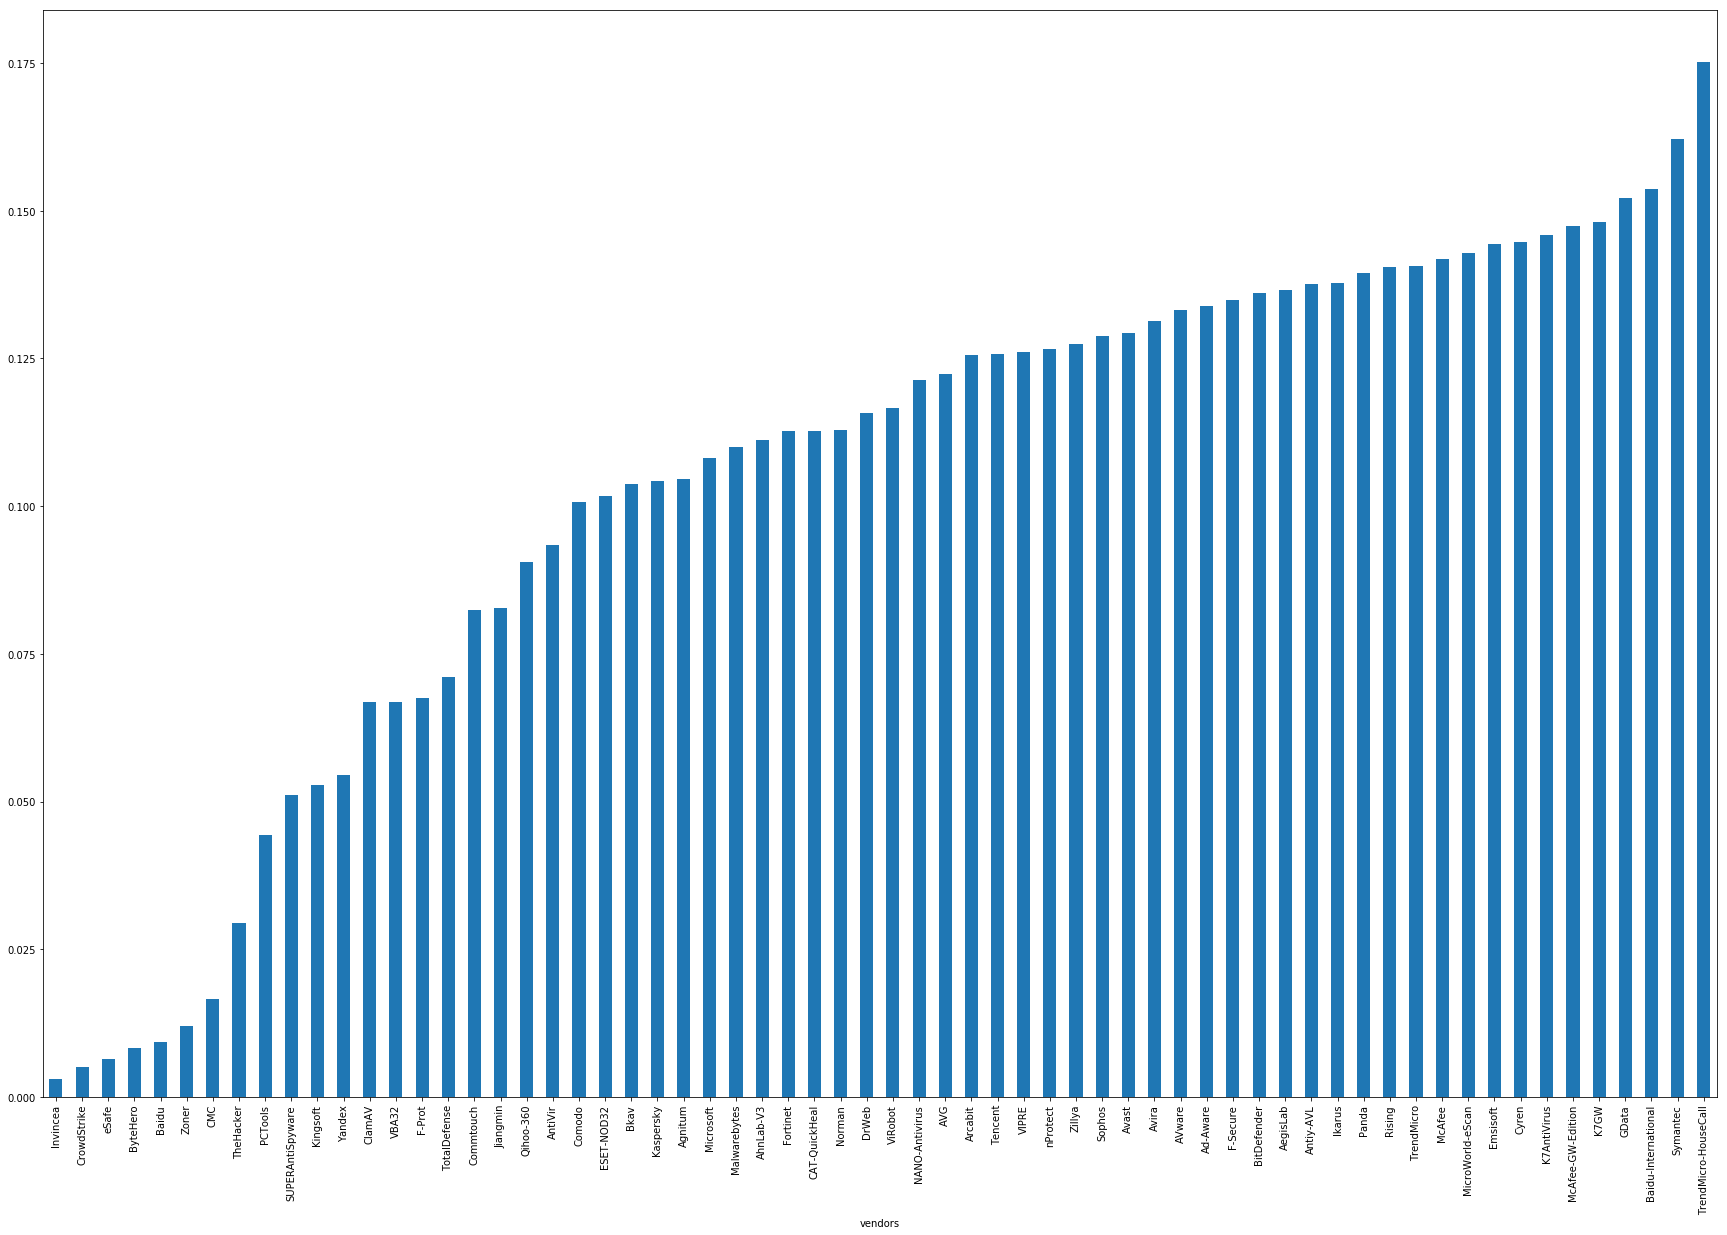

In [11]:
vendors_confidence[vendors_confidence.changes != 0]['ratio'].sort_values().plot.bar(figsize=((30, 20)))
plt.show()

# First and Last Submission Changes

In [12]:
# Duplicated md5s, first and last report
reports_filtered2 = reports_filtered[~reports_filtered.md5.duplicated(keep='first') ^ ~reports_filtered.md5.duplicated(keep='last')]

In [20]:
%%time
# Count the number of times a vendors changes between clean/malware,
# ignores n/a and doesn't count when vendors change malware name
vendors_changes2 = dict()
for v in vendors.columns:
    # [change, unchanged]
    vendors_changes2[v] = [0, 0]


for md5 in list(set(reports_filtered2.md5)):
    temp = reports_filtered2[reports_filtered2.md5 == md5].sort_values('date')
    for v in vendors.columns:
        temp2 = temp[v].dropna()
        if len(temp2) < 2:
            continue
        temp2.replace('Clean', np.nan, inplace=True)
        vendors_changes2[v][1] += len(temp2) - 1
        if not (temp2.count() == 0 or temp2.count() == len(temp2)):
            if temp2[0] != temp2[1] and (temp2[0] != np.nan or temp2[1] != np.nan):
                vendors_changes2[v][0] += 1

CPU times: user 24min 14s, sys: 383 ms, total: 24min 14s
Wall time: 24min 14s


In [22]:
# Save the results
vendors_confidence2 = pd.DataFrame.from_dict(vendors_changes2, orient='index')
vendors_confidence2.index.name = 'vendors'
vendors_confidence2.columns = ['changes', 'total']
vendors_confidence2['ratio'] = vendors_confidence2.changes.divide(vendors_confidence2.total)
vendors_confidence2.to_csv(data_folder + 'vendors_confidence2.csv.gz', compression='gzip')
vendors_confidence2 = pd.read_csv(data_folder + 'vendors_confidence2.csv.gz')
vendors_confidence2 = vendors_confidence2.set_index('vendors')

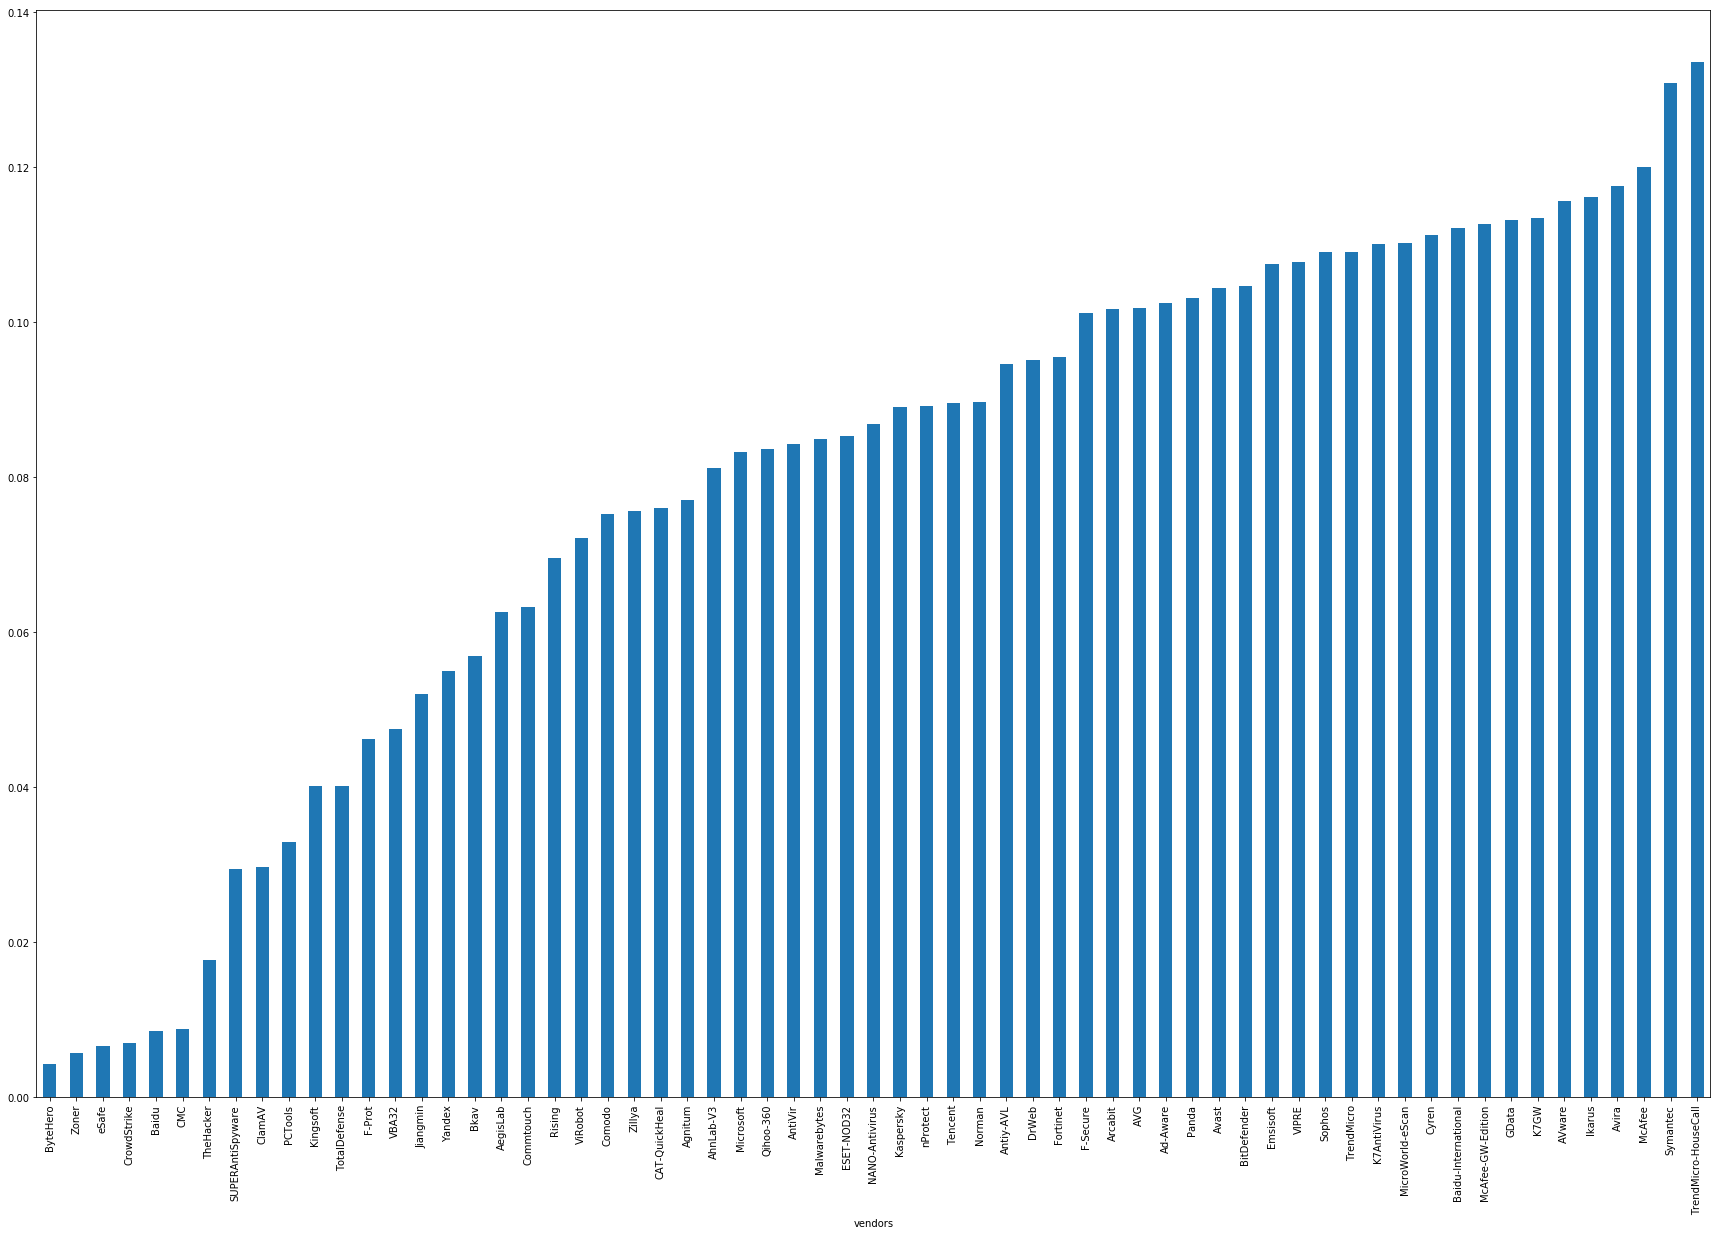

In [23]:
vendors_confidence2[vendors_confidence2.changes != 0]['ratio'].sort_values().plot.bar(figsize=((30, 20)))
plt.show()

# Pioneers

Vendors who are the first to classify a sample as malware

In [67]:
first_dups = reports_vendors.sort_values('date')
# First report of duplicated samples
#    Keep only dups
first_dups = first_dups[first_dups.md5.duplicated(keep=False)]
#    Keep only first dup
first_dups = first_dups[~first_dups.md5.duplicated(keep='first')].drop(['md5', 'date'], axis=1)
pioneers = pd.DataFrame(first_dups.replace('Clean', np.nan).count())
pioneers.index.name = 'vendors'
pioneers.columns = ['first']
pioneers['total'] = first_dups.count()
pioneers['ratio'] = pioneers['first'].divide(pioneers.total)

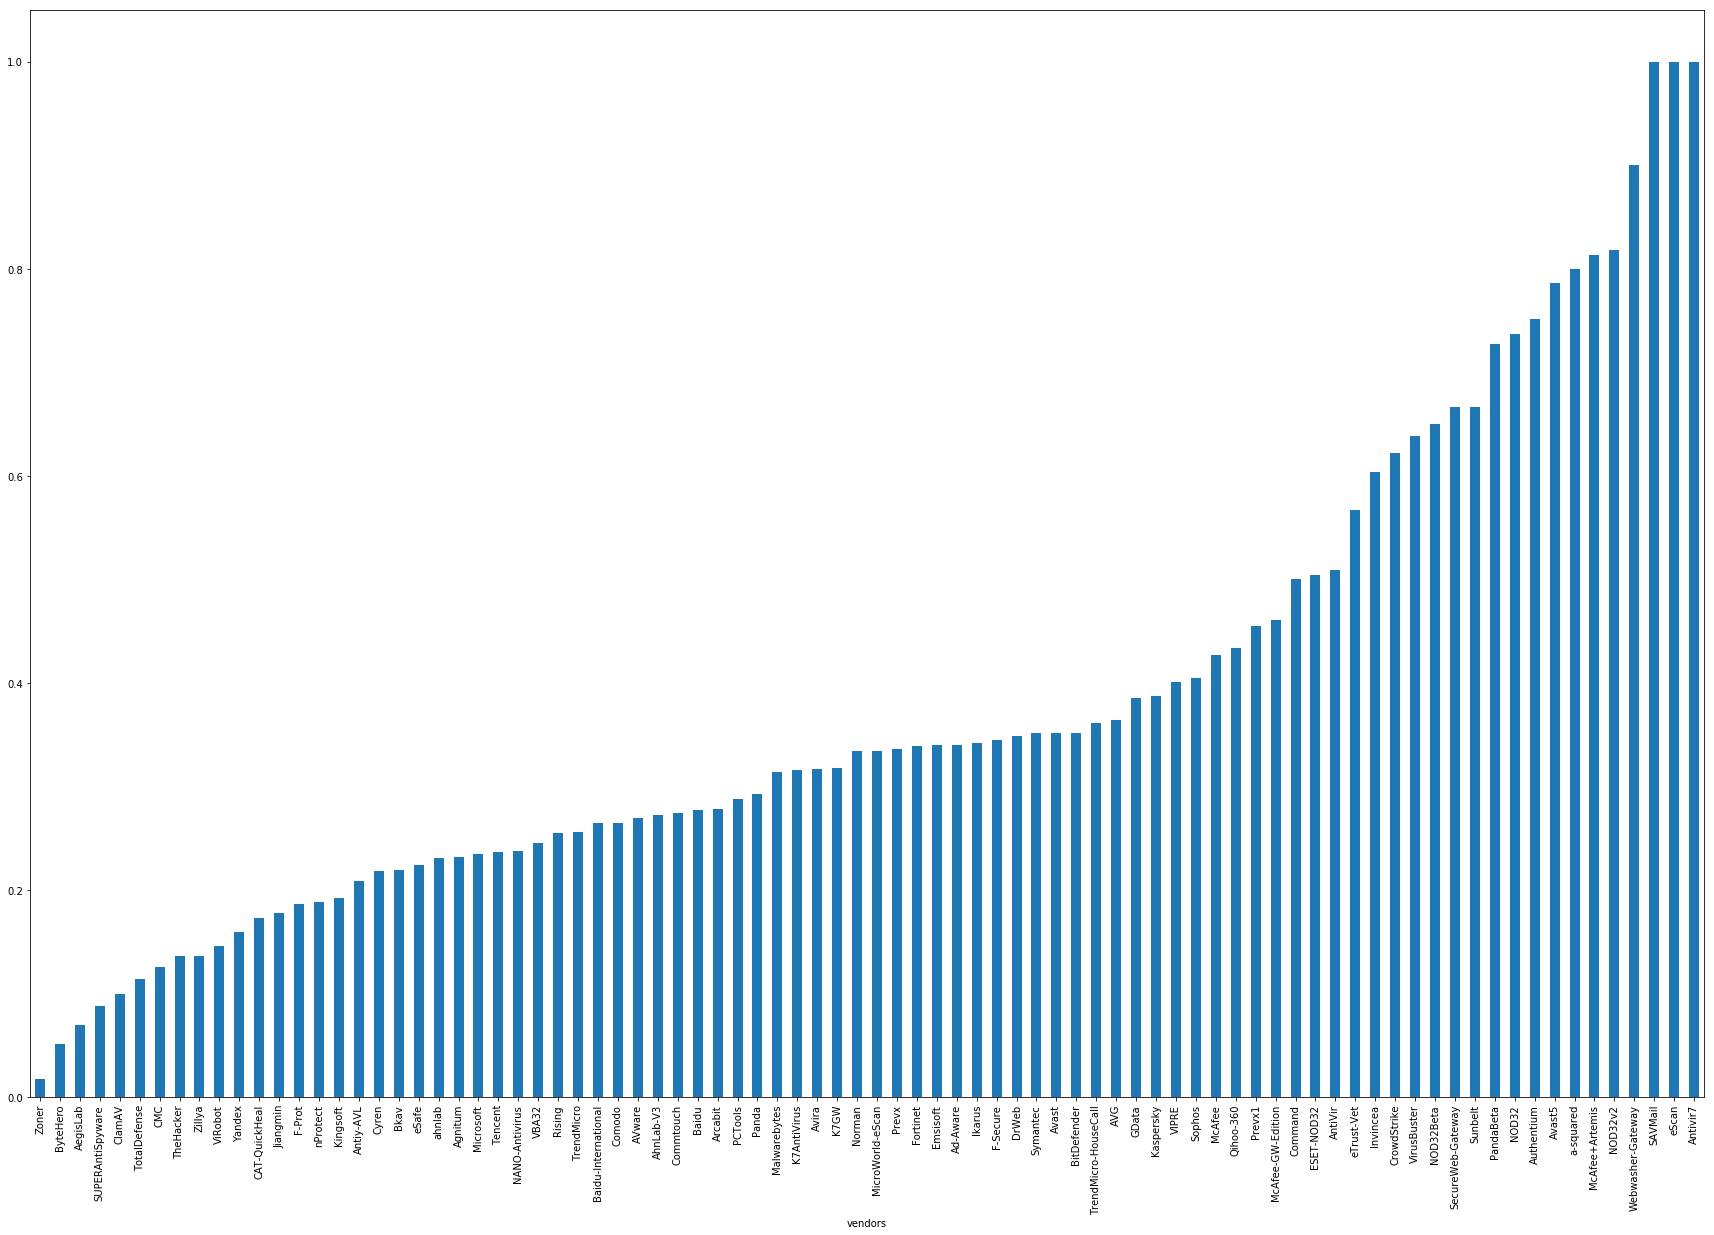

In [15]:
pioneers[pioneers['first'] != 0]['ratio'].sort_values().plot.bar(figsize=((30, 20)))
plt.show()

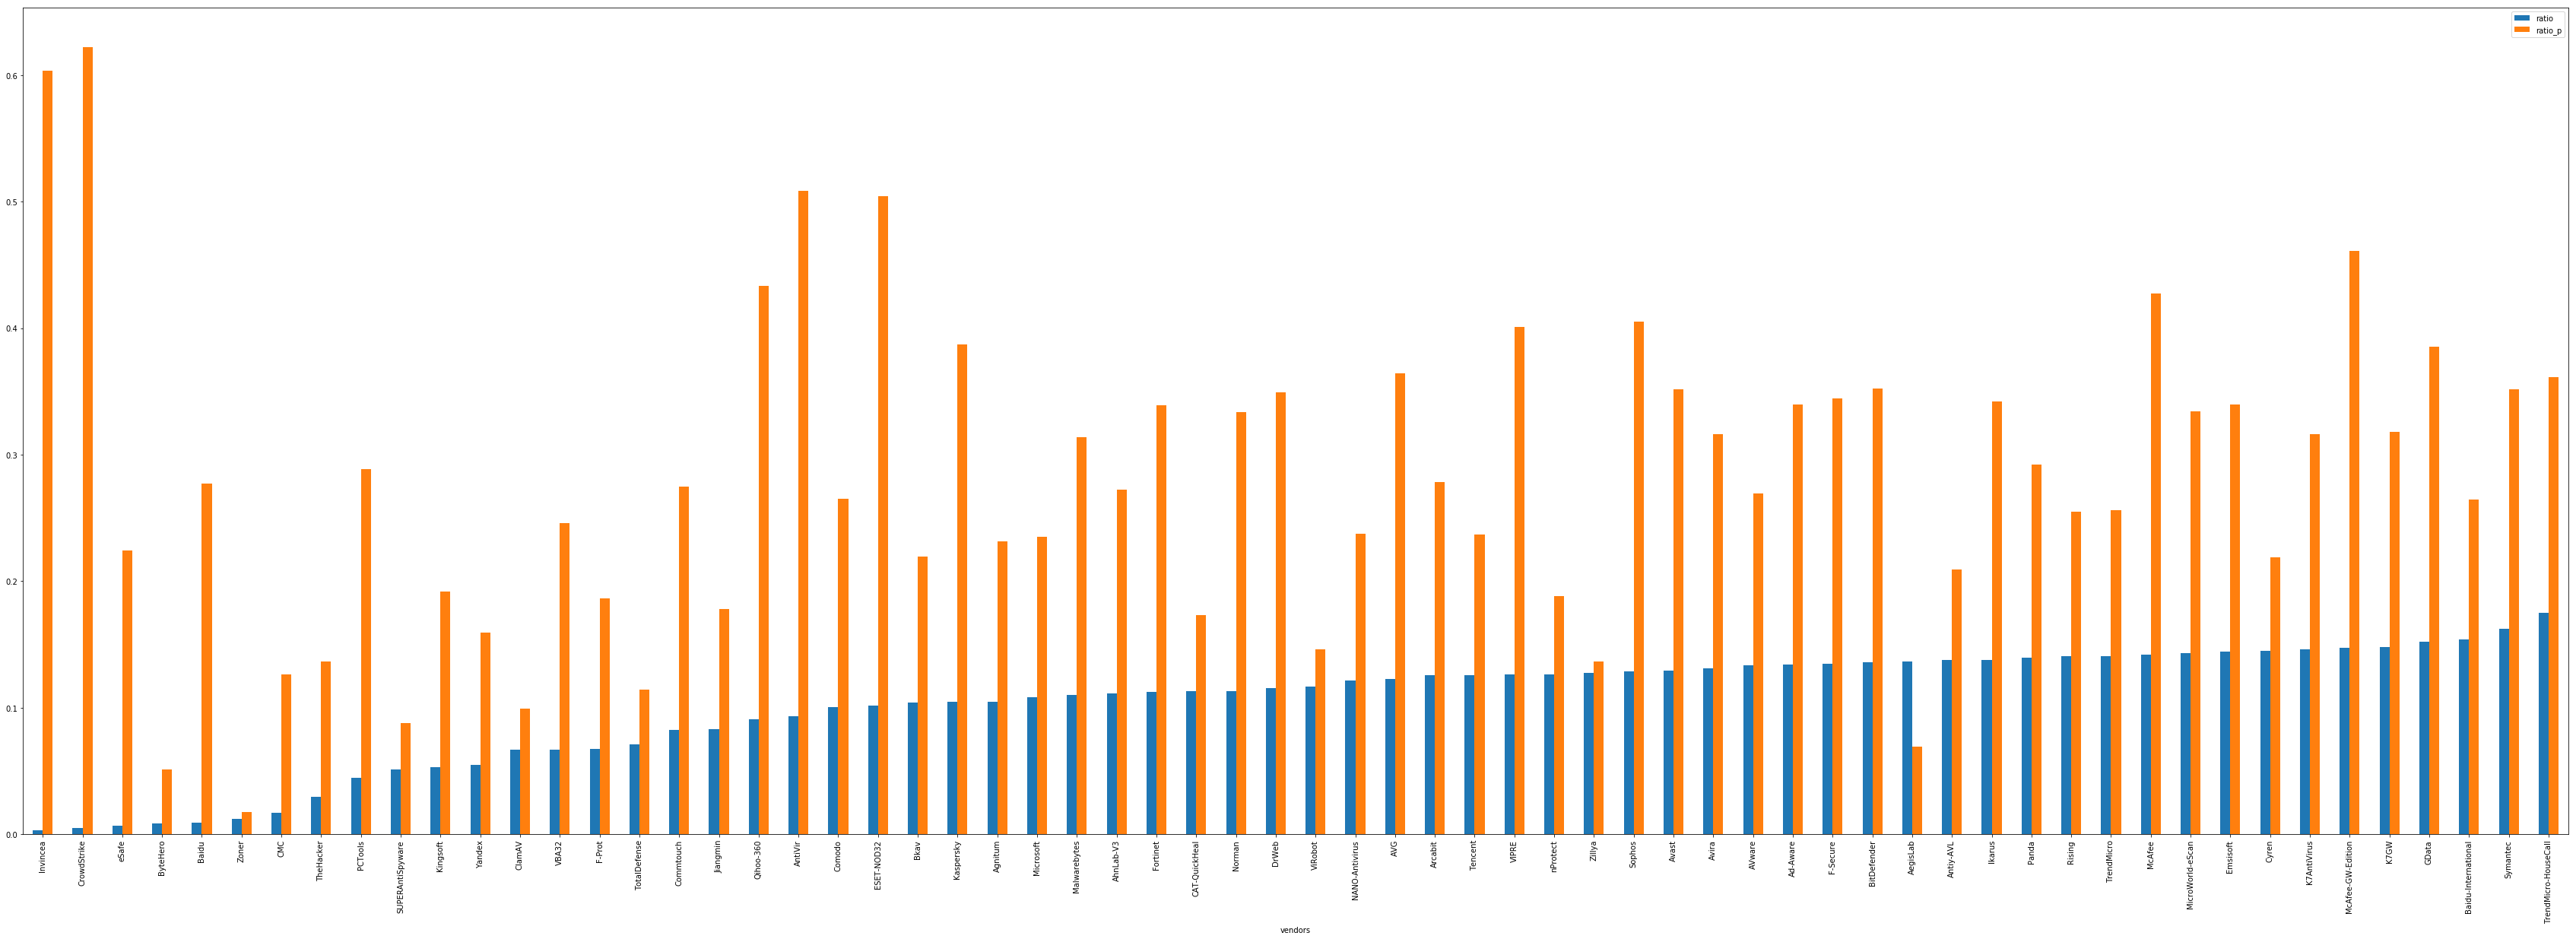

In [16]:
# display(pioneers)
# display(vendors_confidence)
temp = vendors_confidence.join(pioneers['ratio'], rsuffix='_p')
temp[temp.ratio > 0][['ratio', 'ratio_p']].sort_values('ratio').plot.bar(figsize=((60, 20)))
plt.show()

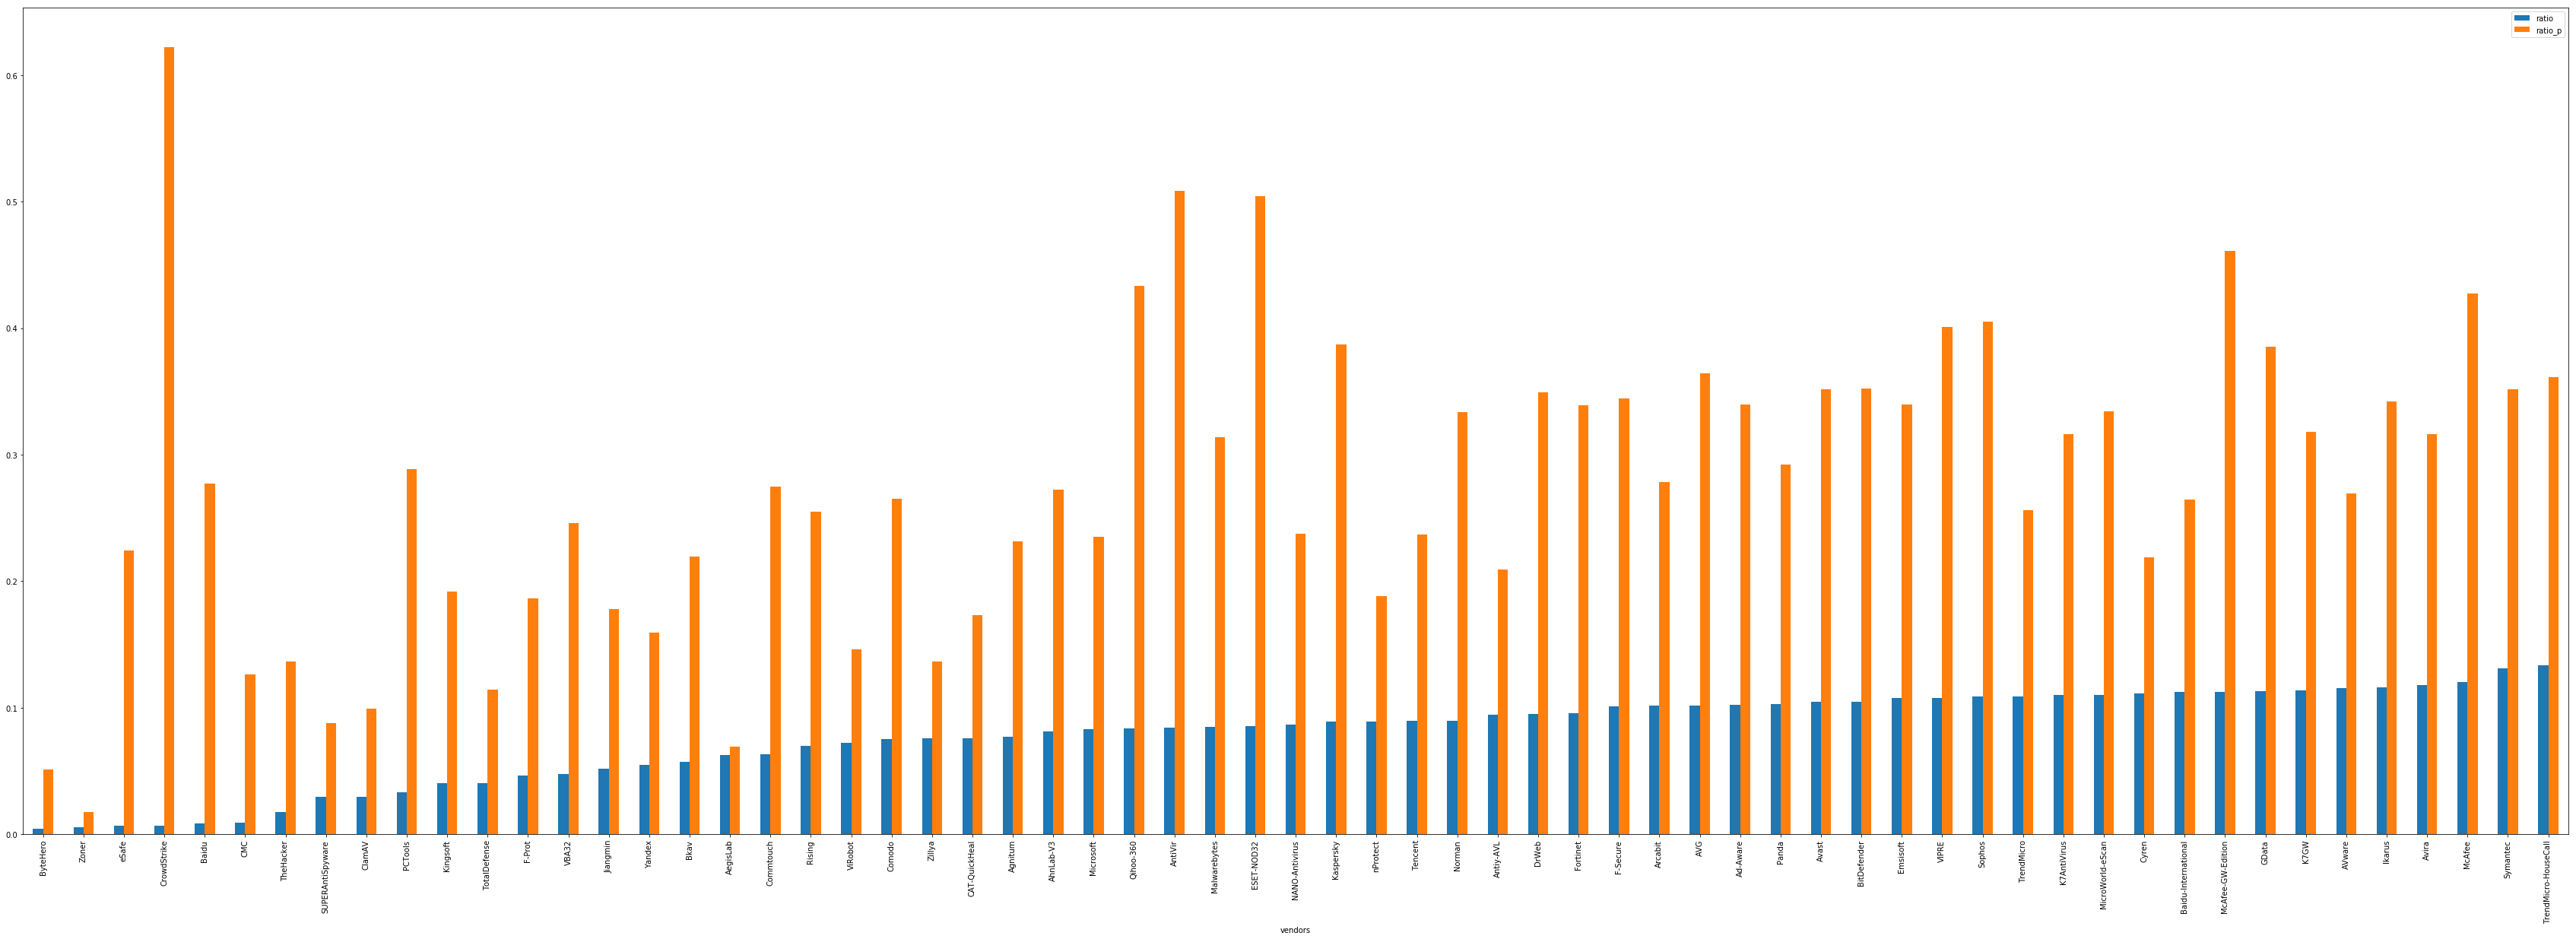

In [25]:
temp = vendors_confidence2.join(pioneers['ratio'], rsuffix='_p')
temp[temp.ratio > 0][['ratio', 'ratio_p']].sort_values('ratio').plot.bar(figsize=((60, 20)))
plt.show()

# First vendors to classify malware

Where malware means >= 6 vendors on the final submission

In [91]:
# Dups which are malware
reports_filtered3 = reports_filtered.sort_values('date').drop_duplicates(keep='last', subset='md5')
# 7 includes date and md5 as columns, meaning > 5 (or >=6)
malware_samples = reports_filtered3.replace('Clean', np.nan)
malware_samples = malware_samples[malware_samples.count(axis=1) > 7]
malware_samples = malware_samples.drop(['md5', 'date'], axis=1)

In [126]:
malware_pioneers = pd.DataFrame(malware_samples.count())
malware_pioneers.index.name = 'vendors'
malware_pioneers.columns = ['first']
# malware_pioneers['total'] = reports_filtered3.count()
malware_pioneers['total'] = reports_filtered3.count()
malware_pioneers['ratio'] = malware_pioneers['first'].divide(malware_pioneers.total)

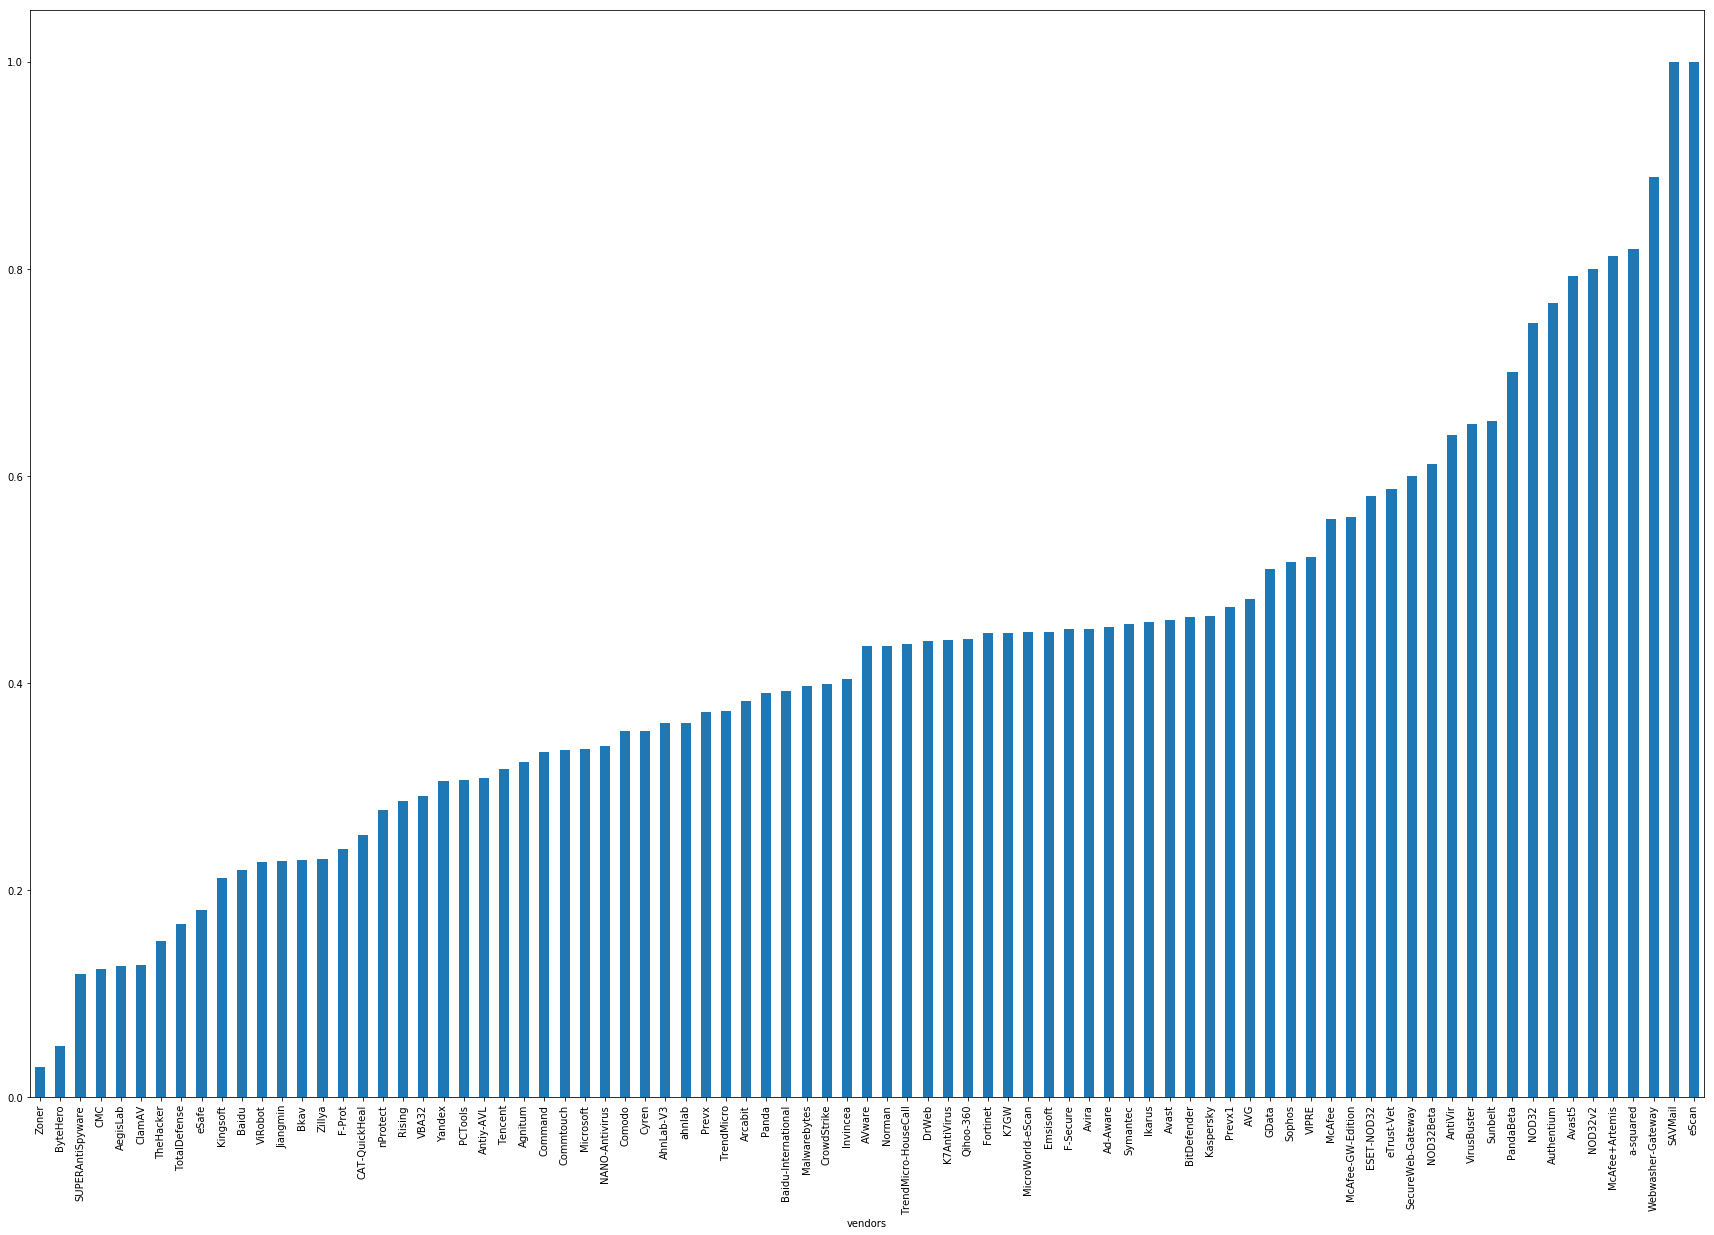

In [127]:
malware_pioneers[malware_pioneers['first'] != 0]['ratio'].sort_values().plot.bar(figsize=((30, 20)))
plt.show()

In [146]:
# display(malware_pioneers[malware_pioneers.total > 28996*.5].sort_values('ratio', ascending=False))
# malware_pioneers[malware_pioneers.index == 'Avira']
b = malware_pioneers[(malware_pioneers.ratio > 0.3) & (malware_pioneers.total > len(malware_samples) / 2)].sort_values('ratio')
display(b.index)
a = vendors[list(b.index)]
a = a.count()/len(a)
display(a[a>0.9])
display(len(a[a>0.9]))

Index(['Antiy-AVL', 'Tencent', 'Agnitum', 'Microsoft', 'NANO-Antivirus',
       'Comodo', 'Cyren', 'AhnLab-V3', 'TrendMicro', 'Arcabit', 'Panda',
       'Baidu-International', 'Malwarebytes', 'AVware', 'Norman',
       'TrendMicro-HouseCall', 'DrWeb', 'K7AntiVirus', 'Qihoo-360', 'Fortinet',
       'K7GW', 'MicroWorld-eScan', 'Emsisoft', 'F-Secure', 'Avira', 'Ad-Aware',
       'Symantec', 'Ikarus', 'Avast', 'BitDefender', 'Kaspersky', 'AVG',
       'GData', 'Sophos', 'VIPRE', 'McAfee', 'McAfee-GW-Edition', 'ESET-NOD32',
       'AntiVir'],
      dtype='object', name='vendors')

Antiy-AVL               0.981546
Microsoft               0.994458
NANO-Antivirus          0.972276
Comodo                  0.993825
AhnLab-V3               0.978503
TrendMicro              0.983654
Panda                   0.975237
Malwarebytes            0.966186
TrendMicro-HouseCall    0.975887
DrWeb                   0.979742
K7AntiVirus             0.996614
Fortinet                0.998963
K7GW                    0.962112
MicroWorld-eScan        0.972324
Emsisoft                0.968610
F-Secure                0.964964
Symantec                0.989056
Ikarus                  0.998093
Avast                   0.993332
BitDefender             0.999271
Kaspersky               0.991278
AVG                     0.992630
GData                   0.997775
Sophos                  0.982443
VIPRE                   0.979742
McAfee                  0.996009
McAfee-GW-Edition       0.989734
ESET-NOD32              0.972098
dtype: float64

28